# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [6]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [15]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

In [17]:
##Sorting data for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final.shape)
final.head()

(100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
153947,166923,B002GWMADK,A12UC87U5NUT0W,VoraciousBuyer,0,0,1,1348531200,High-quality mild decaf green tea,I like this green tea because it is:<br /><br ...
138148,149929,B0028C44IM,A3SW8742TQAQH7,"RalphT ""RalphT""",0,0,1,1326153600,Breath mints are perfect,This was a re-order of this product for me. T...
69745,75881,B002W1F6TK,A1OJZTRLA5K7FF,G. Wedgwood,1,1,1,1301097600,Healthy dog treats,"Excellent! Crunchy, 100% beef nuggets -- a hea..."
121516,131727,B004H4R27E,A2T6FXME2DBNFB,cw713,0,0,1,1336608000,Great for frying your catch!,This is a great tasting product. The descript...
7469,8158,B001IZA8S0,A3HX13IFJH0TMW,Bryan A.,1,1,1,1323907200,Relaxing and Delicious,I have a lemongrass plant in my yard. I make t...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I like this green tea because it is:<br /><br />(1) The leaves look very quality and wholesome<br />(2) It is organically grown<br />(3) It has a very mild pleasing flavor<br />(4) The storage bag conveniently seals<br />(5) For this price, the quality is unbeatable
These are imported from the UK/EU and so the chocolate is much better than anything made in the US. If you've had Bounty in another country, these are exactly the same, and if you've only had Mounds/Almond Joy bars then buy these and let your tastebuds learn a thing or two. Yum. YUM!
the friends who introduced me to this don't even eat gluten-free but they use this as their chocolate chip cookie mix because they think this is the best chocolate chip cookie you can make!<br /><br />I love this mix!!! It is also way, way better than Bob's Red Mill's gluten-free chocolate chip cookie mix (which is too bad, because I really like them & most of their products)<br /><br />great texture, great flavor, great density (not solid but 

In [19]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I like this green tea because it is:<br /><br />(1) The leaves look very quality and wholesome<br />(2) It is organically grown<br />(3) It has a very mild pleasing flavor<br />(4) The storage bag conveniently seals<br />(5) For this price, the quality is unbeatable


In [20]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I like this green tea because it is:(1) The leaves look very quality and wholesome(2) It is organically grown(3) It has a very mild pleasing flavor(4) The storage bag conveniently seals(5) For this price, the quality is unbeatable
These are imported from the UK/EU and so the chocolate is much better than anything made in the US. If you've had Bounty in another country, these are exactly the same, and if you've only had Mounds/Almond Joy bars then buy these and let your tastebuds learn a thing or two. Yum. YUM!
the friends who introduced me to this don't even eat gluten-free but they use this as their chocolate chip cookie mix because they think this is the best chocolate chip cookie you can make!I love this mix!!! It is also way, way better than Bob's Red Mill's gluten-free chocolate chip cookie mix (which is too bad, because I really like them & most of their products)great texture, great flavor, great density (not solid but not too airy)
So delicious, I did not know I loved licorice 

In [21]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

the friends who introduced me to this do not even eat gluten-free but they use this as their chocolate chip cookie mix because they think this is the best chocolate chip cookie you can make!<br /><br />I love this mix!!! It is also way, way better than Bob is Red Mill is gluten-free chocolate chip cookie mix (which is too bad, because I really like them & most of their products)<br /><br />great texture, great flavor, great density (not solid but not too airy)


In [23]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I like this green tea because it is:<br /><br  The leaves look very quality and wholesome<br  It is organically grown<br  It has a very mild pleasing flavor<br  The storage bag conveniently seals<br  For this price, the quality is unbeatable


In [24]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

the friends who introduced me to this do not even eat gluten free but they use this as their chocolate chip cookie mix because they think this is the best chocolate chip cookie you can make br br I love this mix It is also way way better than Bob is Red Mill is gluten free chocolate chip cookie mix which is too bad because I really like them most of their products br br great texture great flavor great density not solid but not too airy 


In [25]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [26]:
# Combining all the above stundents 
from tqdm import tqdm
prepr_rev = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    prepr_rev.append(sentance.strip())

100%|██████████| 100000/100000 [00:50<00:00, 1998.23it/s]


In [27]:
print(len(prepr_rev))
final.shape

100000


(100000, 10)

In [28]:
prepr_rev[1500]

'friends introduced not even eat gluten free use chocolate chip cookie mix think best chocolate chip cookie make love mix also way way better bob red mill gluten free chocolate chip cookie mix bad really like products great texture great flavor great density not solid not airy'

In [29]:
final ['CleanedText']= prepr_rev
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
153947,166923,B002GWMADK,A12UC87U5NUT0W,VoraciousBuyer,0,0,1,1348531200,High-quality mild decaf green tea,I like this green tea because it is:<br /><br ...,like green tea leaves look quality organically...
138148,149929,B0028C44IM,A3SW8742TQAQH7,"RalphT ""RalphT""",0,0,1,1326153600,Breath mints are perfect,This was a re-order of this product for me. T...,order product perfect breath mint come handy tin
69745,75881,B002W1F6TK,A1OJZTRLA5K7FF,G. Wedgwood,1,1,1,1301097600,Healthy dog treats,"Excellent! Crunchy, 100% beef nuggets -- a hea...",excellent crunchy beef nuggets healthy alterna...
121516,131727,B004H4R27E,A2T6FXME2DBNFB,cw713,0,0,1,1336608000,Great for frying your catch!,This is a great tasting product. The descript...,great tasting product description not correct ...
7469,8158,B001IZA8S0,A3HX13IFJH0TMW,Bryan A.,1,1,1,1323907200,Relaxing and Delicious,I have a lemongrass plant in my yard. I make t...,lemongrass plant yard make tea wanted convenie...


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [30]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary) # remove urls from text python: https://stackoverflow.com/a/40823105/4084039 
    summary = BeautifulSoup(summary, 'lxml').get_text() # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip() #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    summary = re.sub('[^A-Za-z]+', ' ', summary) #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    preprocessed_summary.append(summary.strip())



 56%|█████▌    | 56090/100000 [00:17<00:13, 3258.37it/s]/Volumes/Saida/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 100000/100000 [00:31<00:00, 3214.90it/s]


In [31]:
prepr_rev = [i + ' ' + j for i, j in zip(prepr_rev,preprocessed_summary)] 
print(prepr_rev[1500])

friends introduced not even eat gluten free use chocolate chip cookie mix think best chocolate chip cookie make love mix also way way better bob red mill gluten free chocolate chip cookie mix bad really like products great texture great flavor great density not solid not airy maybe best damn chocolate chip cookies ever


# [4] Featurization

## [4.1] BAG OF WORDS

In [32]:
X = np.array(final['CleanedText'])
y = np.array(final['Score'])

In [33]:
from sklearn.model_selection import train_test_split
#splitting data into Train, C.V and Test
X_train, X_test, y_train, y_test = train_test_split(final ['CleanedText'], final['Score'], test_size=0.33) 
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print("Train:",X_train.shape,y_train.shape)
print("CV:",X_cv.shape,y_cv.shape)
print("Test:",X_test.shape,y_test.shape)

Train: (44890,) (44890,)
CV: (22110,) (22110,)
Test: (33000,) (33000,)


In [34]:
#BoW
vectorizer = CountVectorizer(min_df=10, max_features=500) 
vectorizer.fit(X_train)
#vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test) 
print("After vectorizations")
print(X_train_bow.shape, y_train.shape) 
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


## [4.3] TF-IDF

In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test) 
print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape) 
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(44890, 500) (44890,)
(22110, 500) (22110,)
(33000, 500) (33000,)


## [4.4] Word2Vec

In [36]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_test text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

[('fantastic', 0.8507072925567627), ('awesome', 0.8395429849624634), ('good', 0.8194692134857178), ('excellent', 0.8094525933265686), ('wonderful', 0.7896472811698914), ('perfect', 0.744247317314148), ('amazing', 0.7415668964385986), ('terrific', 0.734867513179779), ('nice', 0.6951977014541626), ('fabulous', 0.6404236555099487)]
[('tastiest', 0.7592607140541077), ('best', 0.7539705634117126), ('greatest', 0.7492643594741821), ('smoothest', 0.6626977920532227), ('closest', 0.6370384693145752), ('horrible', 0.6279214024543762), ('compares', 0.6223215460777283), ('awful', 0.619776725769043), ('saltiest', 0.6141097545623779), ('experienced', 0.6079167127609253)]
number of words that occured minimum 5 times  12962


In [37]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12962
sample words  ['labs', 'chicken', 'soup', 'dog', 'lovers', 'also', 'great', 'food', 'seemed', 'getting', 'little', 'bored', 'kibble', 'bought', 'prairie', 'lamb', 'rice', 'coats', 'softer', 'shiny', 'noticable', 'difference', 'two', 'weeks', 'love', 'switching', 'flavors', 'give', 'variety', 'reasonably', 'priced', 'premium', 'holistic', 'shop', 'pet', 'store', 'sales', 'save', 'even', 'would', 'definately', 'recommend', 'product', 'easy', 'set', 'wire', 'fence', 'ready', 'received', 'energizer']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
i=0
sent_of_test_cv=[]
for sentance in X_cv:
    sent_of_test_cv.append(sentance.split())

In [39]:

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_test_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 22110/22110 [00:59<00:00, 369.40it/s]

(22110, 50)
[ 6.46712401e-02 -3.52975899e-01  4.92302150e-01  9.09863875e-02
  1.00296698e+00 -2.60446464e-03 -2.07947951e-01 -7.80456103e-01
  5.23790111e-01 -1.38895452e-01  1.79256746e-01  6.26776293e-01
  6.24966438e-01  3.93841416e-04 -9.25423517e-02  7.04055431e-01
  2.99233822e-01  1.86208594e-02 -1.79614549e-01 -2.89561350e-01
 -1.44980738e-02 -5.29002039e-02  6.00518741e-02  4.14223386e-02
 -4.25162806e-01  6.10605976e-01 -6.25693725e-01  3.29619362e-01
 -2.21529338e-01  7.05666559e-02 -1.50315707e-01 -1.97038289e-01
 -3.24992413e-01 -1.14847526e-01  2.63256302e-01 -2.32312571e-02
  5.39948636e-01  1.03336458e+00 -8.13780364e-01  1.47670526e-01
 -2.97555103e-01  9.06608885e-02  2.06207365e-01 -1.01764707e-02
  3.60310878e-01  1.31050664e-01  6.12660272e-01  7.80724027e-01
 -2.42030407e-01 -2.09266569e-01]


In [40]:
# compute average word2vec for X_test .
test_vectors = []; 
for sent in tqdm(sent_of_test):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)  
    
test_vectors = np.array(test_vectors)

print(test_vectors.shape)
print(test_vectors[0])

100%|██████████| 33000/33000 [01:26<00:00, 380.43it/s]


(33000, 50)
[-1.01276283  0.14425641  0.68173014  0.70570306  0.23754832 -0.40908843
  0.19983431 -0.67782708  0.70915998 -0.24846734  0.16201461  0.42270878
  0.74599672  0.28481896 -0.51668128  0.31355953  0.20360958  0.71648194
 -0.31199088 -0.18056716  0.63985512  0.65358842 -0.10666942 -0.18445801
 -0.32821384  0.50565898 -0.31809535 -0.14268377  0.26001883  0.30798638
  0.01210203 -0.86323097 -0.48955397 -0.47556457 -0.2500978  -0.26662101
  0.15044521  0.95881502 -0.01814436 -0.19702292  0.05316422 -0.34803013
 -0.01712602 -0.04208278 -0.4975351  -0.14703294  1.04416858  0.24650076
 -0.12383749  0.07652589]


In [41]:
# compute average word2vec for X_train .
train_vectors = []; 
for sent in tqdm(sent_of_train):
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
train_vectors = np.array(train_vectors)

print(train_vectors.shape)
print(train_vectors[0])

100%|██████████| 44890/44890 [01:54<00:00, 393.64it/s]


(44890, 50)
[-0.40009983 -0.43564136  0.82301273 -0.10895452  0.21664387 -0.46494384
 -0.07864228  0.04020032  0.58628824 -0.27865495  0.23309086  0.19088887
  0.58127333  0.2966594  -0.26410347 -0.06450366 -0.29119727  0.22417836
 -0.49186427 -0.4475818   0.05089539  0.33734576 -0.13717777  0.30100819
 -0.54215029  0.1405718  -0.10719035  0.3024686   0.23967941 -0.4827349
 -0.7155806   0.14274824  0.55151182 -0.19837177  0.34081935 -0.58546564
  0.4500563   0.47166665 -0.35723679 -0.24917104 -0.36343603  0.23296906
 -0.94260318 -0.34233952 -0.3489895   0.23489252 -0.30933715  0.67176588
 -0.63670686  0.52221066]


#### [4.4.1.2] TFIDF weighted W2v

In [42]:
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in tqdm(sent_of_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    
tfidf_test_vectors = np.array(tfidf_test_vectors)
print(tfidf_test_vectors.shape)
print(tfidf_test_vectors[0])

100%|██████████| 33000/33000 [19:36<00:00, 28.05it/s]

(33000, 50)
[-0.90583639  0.18735425  0.54923324  0.67834463  0.18499273 -0.33317598
  0.23725528 -0.79149165  0.62644982 -0.23805753  0.11335978  0.44734548
  0.66796856  0.35269967 -0.45216802  0.214916    0.2174245   0.50478152
 -0.22982137 -0.15205063  0.51498101  0.54789954 -0.16259114 -0.04535524
 -0.42746938  0.39095321 -0.31773702 -0.13467749  0.27698708  0.35076738
 -0.12198095 -0.70004635 -0.2987131  -0.33743193 -0.2685451  -0.26766689
  0.15898748  0.95188318 -0.02797757 -0.39917058  0.07934803 -0.38129837
  0.05017205 -0.05356487 -0.47623262 -0.17533946  1.03841643  0.32985956
 -0.07308841  0.0735464 ]


In [43]:
# TF-IDF weighted Word2Vec.
tfidf_train_vectors = []; 
row=0;
for sent in tqdm(sent_of_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)

tfidf_train_vectors = np.array(tfidf_train_vectors)
print(tfidf_train_vectors.shape)
print(tfidf_train_vectors[0])

100%|██████████| 44890/44890 [30:57<00:00, 24.16it/s] 


(44890, 50)
[-0.18287831 -0.40228735  0.9256302  -0.17913426  0.09782794 -0.36189132
  0.0386502   0.2495045   0.50485755 -0.20739936  0.32368299  0.19608155
  0.55968764  0.4475972  -0.29176013 -0.13120472 -0.45375064  0.12317831
 -0.65697991 -0.45859406 -0.12515345  0.38660385 -0.18532818  0.38817971
 -0.51344629  0.01390275 -0.38785151  0.36350828  0.34795726 -0.46949204
 -0.92954534  0.18314032  0.58732073 -0.08698579  0.36775165 -0.57380523
  0.2962493   0.31183704 -0.39251479 -0.26711088 -0.44270847  0.25442182
 -0.98342732 -0.47646536 -0.38935788  0.34390487 -0.33726189  0.71749737
 -0.68967043  0.55585096]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [44]:
# Please write all the code with proper documentation

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import GridSearchCV

def svm_all (X_train,y_train,X_cv):
    
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10,10**2,10**3,10**4]
    Penal = ['l1','l2']
    hyper_param = {'alpha':Alpha, 'penalty':Penal}
    
    clf = GridSearchCV(SGDClassifier(loss='hinge'),hyper_param,verbose=1,scoring='roc_auc')
    clf.fit(X_train_bow,y_train)
    calbr = CalibratedClassifierCV(clf, method = "sigmoid")
    alpha_opt, penalty_opt = clf.best_params_.get('alpha'), clf.best_params_.get('penalty') 
    
    
    train_auc = clf.cv_results_.get('mean_train_score')
    cv_auc = clf.cv_results_.get('mean_test_score')
    x2 = np.arange(len(Alpha))
    

    plt.plot(x2, train_auc[1::2],'r--', label = 'Train Data')
    plt.plot(x2,cv_auc[1::2],'b--', label = 'CV Data')
    plt.xticks(x2, Alpha)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("C: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    print("Optimal value of Alpha: ", alpha_opt , " and Penalty is : ", penalty_opt)
    #Cv auc scores 
    print("--------------------------")
    print("Cv auc scores")
    print(cv_auc)
    print("Maximun Auc value :",max(cv_auc))
    
    #test data
    
    sgd = SGDClassifier(penalty=penalty_opt,alpha=alpha_opt,class_weight='balanced')
    sgd.fit(X_train_bow,y_train)
    
    train_fpr, train_tpr, thresholds = roc_curve(y_train, sgd.decision_function(X_train_bow))
    test_fpr, test_tpr, thresholds = roc_curve(y_test, sgd.decision_function(X_test_bow))                                             
                                                 
    
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("C: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
     
     
     #Confusion Matrix
    
    print("Train confusion matrix") 
    print(confusion_matrix(y_train, sgd.predict(X_train_bow))) 
    print("Test confusion matrix")
    print(confusion_matrix(y_test, sgd.predict(X_test_bow)))
 
    cm = confusion_matrix(y_train, sgd.predict(X_train_bow))
    cm = confusion_matrix(y_test, sgd.predict(X_test_bow))
    tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

    # Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    5.3s finished


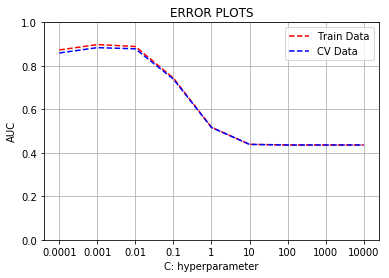

Optimal value of Alpha:  0.001  and Penalty is :  l2
--------------------------
Cv auc scores
[0.84601524 0.85911213 0.86652901 0.88373628 0.68108755 0.8782753
 0.50679618 0.73890348 0.5        0.51672274 0.5        0.43868337
 0.5        0.43593929 0.5        0.4359367  0.5        0.43593667]
Maximun Auc value : 0.8837362776296454


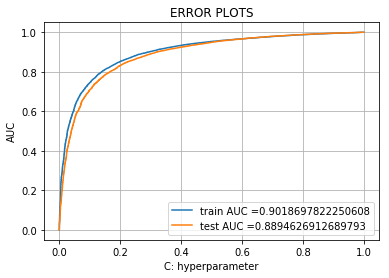

Train confusion matrix
[[ 6137   919]
 [ 7969 29865]]
Test confusion matrix
[[ 4415   807]
 [ 5856 21922]]


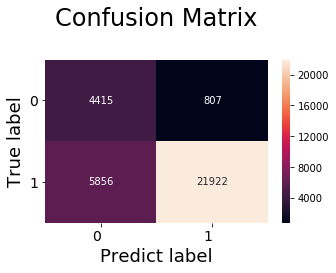

In [45]:
svm_all(X_train_bow,y_train,X_cv_bow)

In [46]:
# Please write all the code with proper documentation
 
sgd = SGDClassifier(penalty='l2',alpha=0.001)
sgd.fit(X_train_bow, y_train)
feat_log = sgd.coef_

vectorizer = CountVectorizer(min_df=10, max_features=500)
p = vectorizer.fit_transform(X_train)
p = pd.DataFrame(feat_log.T,columns=['+ve'])
p['feature'] = vectorizer.get_feature_names()

q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 10 features positive class", np.array(q['feature'][:10]))

Top 10 features positive class ['delicious' 'best' 'perfect' 'excellent' 'fantastic' 'amazing' 'great'
 'loves' 'wonderful' 'yummy']


In [47]:
# Please write all the code with proper documentation
print("Top 10 features negative class",np.array(q.tail(10)['feature']))

Top 10 features negative class ['maybe' 'artificial' 'received' 'opened' 'thought' 'item' 'bad' 'away'
 'money' 'disappointed']


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    5.9s finished


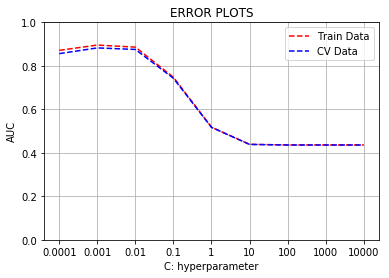

Optimal value of Alpha:  0.001  and Penalty is :  l2
--------------------------
Cv auc scores
[0.85615156 0.85616223 0.86020422 0.88249536 0.63049843 0.87539981
 0.52293587 0.74278906 0.5        0.51720729 0.5        0.43870516
 0.5        0.43593924 0.5        0.43593751 0.5        0.43593667]
Maximun Auc value : 0.8824953566727332


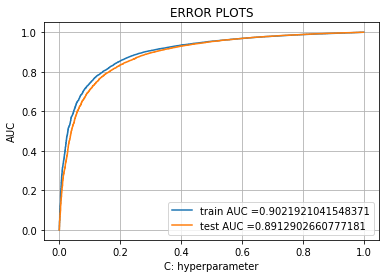

Train confusion matrix
[[ 6233   823]
 [ 8713 29121]]
Test confusion matrix
[[ 4529   693]
 [ 6526 21252]]


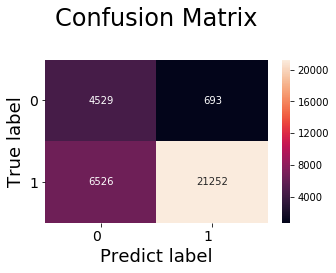

In [48]:
# Please write all the code with proper documentation
svm_all(X_train_tfidf,y_train,X_cv_tfidf)

In [49]:
sgd = SGDClassifier(penalty='l2',alpha=0.001)
sgd.fit(X_train_tfidf,y_train)
feat_log = sgd.coef_

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
p = tf_idf_vect.fit_transform(X_train)
p = pd.DataFrame(feat_log.T,columns=['+ve'])
p['feature'] = tf_idf_vect.get_feature_names()


q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 10 features positive class", np.array(q['feature'][:10]))

Top 10 features positive class ['great' 'best' 'good' 'love' 'delicious' 'perfect' 'loves' 'excellent'
 'wonderful' 'amazing']


In [50]:
# Please write all the code with proper documentation
print("Top 10 features negative class",np.array(q.tail(10)['feature']))

Top 10 features negative class ['opened' 'thought' 'maybe' 'not even' 'away' 'bad' 'would not' 'not'
 'money' 'disappointed']


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    6.7s finished


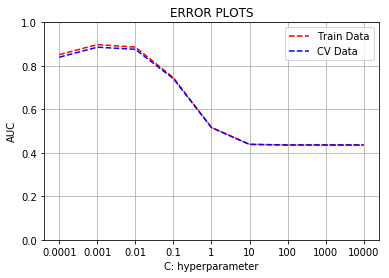

Optimal value of Alpha:  0.001  and Penalty is :  l2
--------------------------
Cv auc scores
[0.84906137 0.83984384 0.85853664 0.88579769 0.70137577 0.87606268
 0.52096502 0.74089528 0.5        0.51577913 0.5        0.43873388
 0.5        0.43593935 0.5        0.43593673 0.5        0.43593712]
Maximun Auc value : 0.8857976924656128


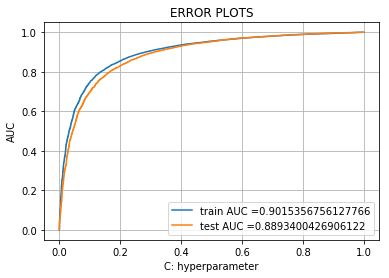

Train confusion matrix
[[ 6126   930]
 [ 7742 30092]]
Test confusion matrix
[[ 4397   825]
 [ 5791 21987]]


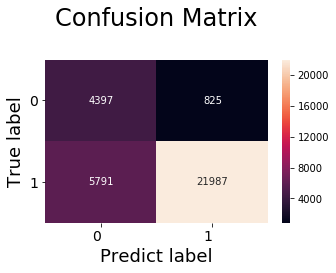

In [51]:
svm_all(train_vectors, y_train, X_cv)      

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    6.4s finished


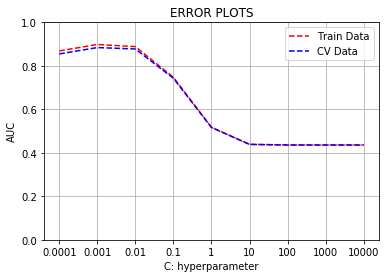

Optimal value of Alpha:  0.001  and Penalty is :  l2
--------------------------
Cv auc scores
[0.85278642 0.85492238 0.86438725 0.88406984 0.64815774 0.87751864
 0.51634944 0.74259893 0.5        0.51645067 0.5        0.43873109
 0.5        0.43593981 0.5        0.43593671 0.5        0.43593669]
Maximun Auc value : 0.8840698421090125


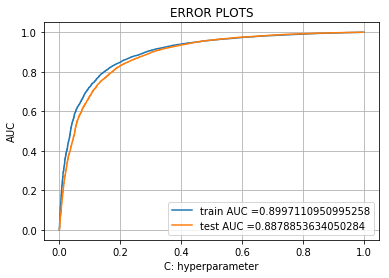

Train confusion matrix
[[ 5455  1601]
 [ 4988 32846]]
Test confusion matrix
[[ 3908  1314]
 [ 3691 24087]]


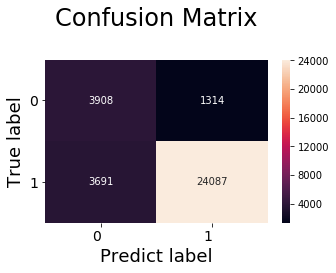

In [52]:
# Please write all the code with proper documentation
svm_all(tfidf_train_vectors,y_train,X_cv)

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [53]:
##Sorting data for Time Based Splitting
from sklearn.model_selection import train_test_split
 
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


df_final = time_sorted_data.take(np.random.permutation(len(final))[:50000])
print(df_final.shape)
df_final.head()

 

(50000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
157508,170797,B001SB6CJ8,A3ICDLUQ3V2QY2,"Kevin L. Nenstiel ""omnivore""",1,2,0,1277683200,Too Acidic,"As I began eating, I thought this would be a p...",began eating thought would pleasingly pungent ...
59004,64098,B000O7V3QO,A3530DRMCQ2SQ4,"C. McCashin ""Gemini in Tennessee""",0,0,1,1240531200,"IMHO, the best coffee",This coffee along with the Tassimo coffee mach...,coffee along tassimo coffee machine makes best...
197832,214414,B0037N7GIQ,A3BTF24CZFBYUR,Judy,0,1,1,1320796800,Bran Flakes - No Raisins,"The trouble with ""Raisin Bran"", where the rais...",trouble raisin bran raisins already mixed rais...
75370,82016,B003A8BE4U,AYLKRFOG2KIT5,Ed Johnston,3,3,1,1275696000,Great Garden,This is a great gift. I was looking for someth...,great gift looking something different wife mo...
22393,24508,B0016JJEFG,A3JZ5Q0VEWW2PY,Jessica Clifford,5,5,1,1264982400,Best tea by far,I have been using Newman's products for 5 year...,using newman products years recently bought bl...


In [54]:
X = df_final['CleanedText'].values
y = df_final['Score'].values

# split the data set into train and test
#X_rbf, X_test, y_rbf, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
#X_train, X_cv, y_train, y_cv = train_test_split(X_rbf, y_rbf, test_size=0.3,random_state=0)

In [55]:
y_train=time_sorted_data['Score'][0:13000]
y_cv=time_sorted_data['Score'][13000:16000]
y_test=time_sorted_data['Score'][16000:20000]

In [56]:
X_train=time_sorted_data["CleanedText"][0:13000]
X_cv=time_sorted_data["CleanedText"][13000:16000]
X_test=time_sorted_data["CleanedText"][16000:20000]

In [57]:
print(X_train.shape, "   ", y_train.shape)
print(X_cv.shape, "   ", y_cv.shape)
print(X_test.shape, "   ", y_test.shape)

(13000,)     (13000,)
(3000,)     (3000,)
(4000,)     (4000,)


In [58]:
from sklearn.preprocessing import StandardScaler
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
vectorizer.fit_transform(X_train)
X_train_bow = vectorizer.transform(X_train)
X_cv_bow  = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)


In [59]:
print(X_train_bow.shape)
print(X_cv_bow.shape)
print(X_test_bow.shape)

(13000, 500)
(3000, 500)
(4000, 500)


In [60]:
vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
tf_idf_vect = vect.fit(X_train)


X_train_tfidf = tf_idf_vect.transform(X_train)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
X_test_tfidf = tf_idf_vect.transform(X_test) 

print(X_train_tfidf.shape)
print(X_cv_tfidf.shape)
print(X_test_tfidf.shape)

(13000, 300)
(3000, 300)
(4000, 300)


In [70]:
from sklearn.svm import SVC 
def all_rbf(X_train, y_train,X_cv):
    C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    hyper_param  = [{'C':C}]
    
     
    clf = GridSearchCV(SVC(kernel = "rbf", probability=True), hyper_param, cv = 3, scoring = "roc_auc")
    clf.fit(X_train_bow,y_train)
    alpha_opt = clf.best_params_.get("C") 


    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

    plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("C: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    
    print("Optimal value of C: ", alpha_opt)
    
    #Cv auc scores 
    print("--------------------------")
    print("Cv auc scores")
    print(cv_auc)
    print("Maximun Auc value :",max(cv_auc))
 
    
    gamma = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    tunned_param  = [{'gamma':gamma}]
    clf = GridSearchCV(SVC(kernel = "rbf", probability=True), tunned_param, cv = 3, scoring = "roc_auc")
    clf.fit(X_train_bow,y_train)
    gamma_opt = clf.best_params_.get("gamma")

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    
    
    plt.plot(train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("Gamma: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
     
    print("Optimal value of gamma: ", gamma_opt)

      
    model = SVC(C=alpha_opt, gamma = gamma_opt, kernel = "rbf",class_weight='balanced', probability=True)
    model.fit(X_train_bow,y_train)

    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_bow)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_bow)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.legend()
    plt.xlabel("hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()                                           
                                                     
   
     #Confusion Matrix
    
    print("Train confusion matrix") 
    print(confusion_matrix(y_train, model.predict(X_train_bow))) 
    print("Test confusion matrix")
    print(confusion_matrix(y_test, model.predict(X_test_bow)))
 
    cm = confusion_matrix(y_train, model.predict(X_train_bow))
    cm = confusion_matrix(y_test, model.predict(X_test_bow))
    tn, fp, fn, tp = cm.ravel()
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
# Code for drawing seaborn heatmaps
    class_names = ['0','1']
    df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
    fig = plt.figure(figsize=(5,3))
    heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    plt.ylabel('True label',size=18)
    plt.xlabel('Predict label',size=18)
    plt.title("Confusion Matrix\n",size=24)
    plt.show()

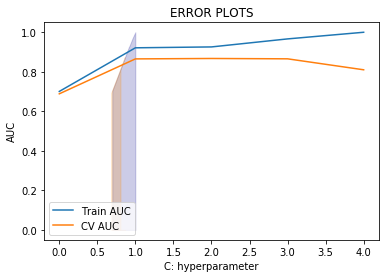

Optimal value of C:  1
--------------------------
Cv auc scores
[0.68799675 0.8645555  0.86665877 0.86491564 0.80950303]
Maximun Auc value : 0.8666587740126928


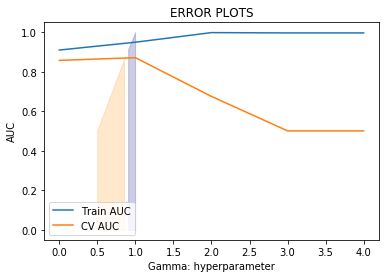

Optimal value of gamma:  0.01


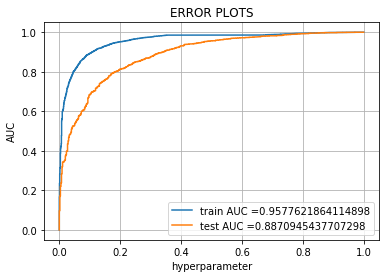

Train confusion matrix
[[ 1325   118]
 [ 1510 10047]]
Test confusion matrix
[[ 421  133]
 [ 553 2893]]


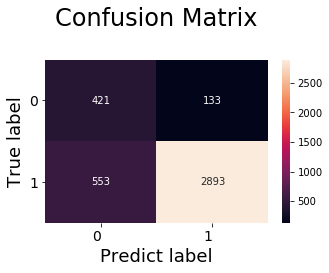

In [71]:
all_rbf(X_train_bow,y_train,X_cv_bow)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

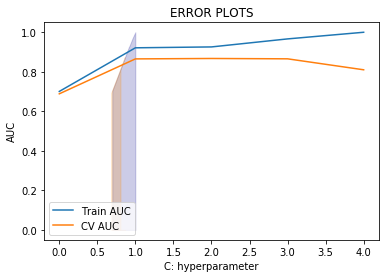

Optimal value of C:  1
--------------------------
Cv auc scores
[0.68799675 0.8645555  0.86665877 0.86491564 0.80950303]
Maximun Auc value : 0.8666587740126928


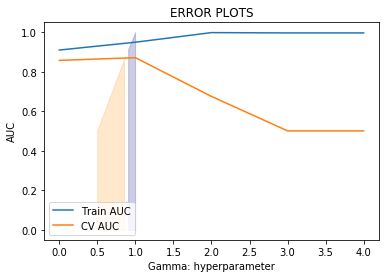

Optimal value of gamma:  0.01


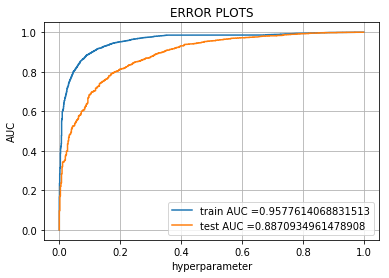

Train confusion matrix
[[ 1325   118]
 [ 1510 10047]]
Test confusion matrix
[[ 421  133]
 [ 553 2893]]


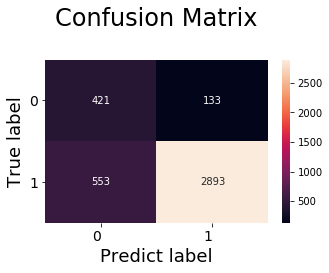

In [72]:
# Please write all the code with proper documentation
all_rbf(X_train_tfidf,y_train,X_cv_tfidf)

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

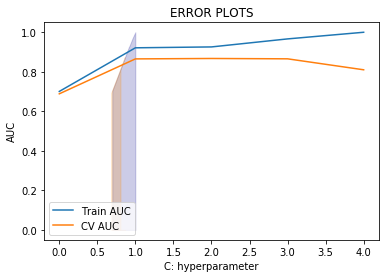

Optimal value of C:  1
--------------------------
Cv auc scores
[0.68799675 0.8645555  0.86665877 0.86491564 0.80950303]
Maximun Auc value : 0.8666587740126928


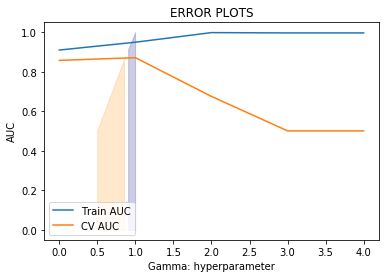

Optimal value of gamma:  0.01


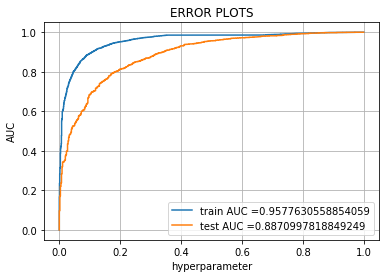

Train confusion matrix
[[ 1325   118]
 [ 1510 10047]]
Test confusion matrix
[[ 421  133]
 [ 553 2893]]


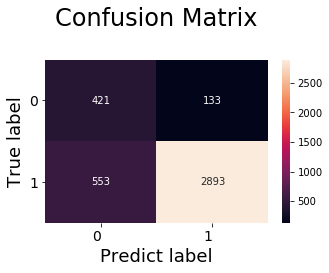

In [73]:
all_rbf(train_vectors,y_train,X_cv)

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

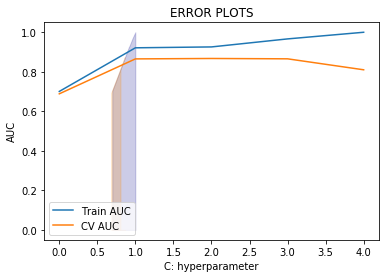

Optimal value of C:  1
--------------------------
Cv auc scores
[0.68799675 0.8645555  0.86665877 0.86491564 0.80950303]
Maximun Auc value : 0.8666587740126928


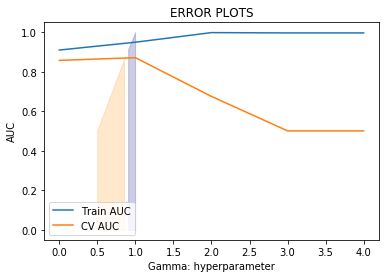

Optimal value of gamma:  0.01


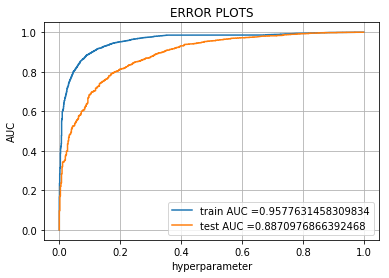

Train confusion matrix
[[ 1325   118]
 [ 1510 10047]]
Test confusion matrix
[[ 421  133]
 [ 553 2893]]


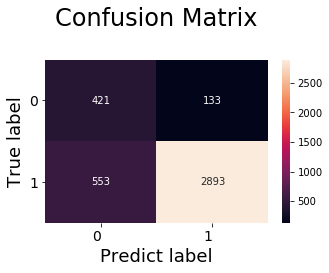

In [74]:
# Please write all the code with proper documentation

all_rbf(train_vectors,y_train,X_cv)

# [6] Conclusions

In [75]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

# Names of models
Vectorizer = ['Bag of Words','TFIDF','AVG W2V','TFIDF W2V','Bag of Words', 'TFIDF', 'AVG W2V','TFIDF W2V']


hyper_Param=[0.001, 0.001,0.001,0.001,1, 1,1, 1]

auc =[0.88,0.88,0.88,0.88,0.86,0.86,0.86,0.86]
 
numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering) 
ptable.add_column("MODEL",Vectorizer)
 
ptable.add_column("Hyper Parameter",hyper_Param)
ptable.add_column("AUC",auc)
 

print(ptable)

+-------+--------------+-----------------+------+
| S.NO. |    MODEL     | Hyper Parameter | AUC  |
+-------+--------------+-----------------+------+
|   1   | Bag of Words |      0.001      | 0.88 |
|   2   |    TFIDF     |      0.001      | 0.88 |
|   3   |   AVG W2V    |      0.001      | 0.88 |
|   4   |  TFIDF W2V   |      0.001      | 0.88 |
|   5   | Bag of Words |        1        | 0.86 |
|   6   |    TFIDF     |        1        | 0.86 |
|   7   |   AVG W2V    |        1        | 0.86 |
|   8   |  TFIDF W2V   |        1        | 0.86 |
+-------+--------------+-----------------+------+


## conclusion
1. Linear kernel is faster than RBF Kernel.
2. BOW featurisation with Linear kernel and  L2 regularization gave 88% AUC value.
3. Model can be improved by more data points although we notice that SVM doesnt perform well this dataset because the other model we have applied were better results than this.